<a href="https://colab.research.google.com/github/Koalajuni/Naver_AI_Project/blob/main/%ED%95%98%EC%9D%B4%ED%8D%BC_%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0_%ED%8A%9C%EB%8B%9D_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [10차시] 하이퍼 파라미터 튜닝 연습

* 세번째 베이스라인 모델에서 LightGBM에 Optuna를 이용하고 하이퍼 파라미터 튜닝을 적용합니다.

## Function 정의

- seed_everything() : seed 고정 함수
- generate_label() : label 생성 함수
- print_score() : 평가지표 출력 함수
- feature_preprocessing() : 데이터 전처리 함수(label encoding, 결측치 처리)
- feature_engineering1() : 피처 엔지니어링 함수
- make_lgb_oof_prediction() : LightGBM cross validation out of fold train/predict 함수
- plot_feature_importances() : 피처 중요도 플롯 함수
- objective() : optuna objective 함수

In [15]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.6 MB/s eta 0:00:00


## Library Import

In [48]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random
from typing import List

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
import optuna

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

## Fix Seed 함수 정의

In [49]:
'''
    결과의 재현성을 위해 seed 값을 설정하는 함수
'''
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)

## 레이블 생성 함수 정의

- 레이블 생성 함수는 연월을 인자로 받아서 고객 아이디별로 총 구매액이 인자로 받는 구매액 임계값을 넘는지 여부를 바이너리 레이블로 생성하는 함수

In [50]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()

    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]

    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month

    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()

    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')

    return label

## 평가지표 출력 함수 정의

In [51]:
'''
    평가지표를 출력하는 함수
'''
def print_score(label: List[float], pred: List[float], prob_thres: float = 0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

## 데이터 전처리 함수 정의
- 범주형 변수 레이블 인코딩
- 결측치 중위값으로 채움

In [52]:
'''
    입력인자로 받는 train, test 데이터에 대해 범주형 피쳐는 레이블 인코딩을
    진행하고 결측치에 대해서는 중위값으로 데이터 전처리를 하는 함수
'''
def feature_preprocessing(
    train: pd.DataFrame,
    test: pd.DataFrame,
    features: list,
    do_imputing=True
):
    x_tr = train.copy()
    x_te = test.copy()

    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))

            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))

            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')

        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])

    return x_tr, x_te

## 피처 엔지니어링 함수 정의
- Pandas groupby aggregation 함수를 사용한 피처 엔지니어링

In [53]:
'''
    입력인자로 받는 year_month와 변수 prev_ym 기준으로 train, test 데이터를 생성 하고
    집계(aggregation) 함수를 사용하여 피처 엔지니어링을 하는 함수
'''
def feature_engineering1(df: pd.DataFrame, year_month: str):
    df = df.copy()

    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')

    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]

    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]

    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    all_train_data = pd.DataFrame()

    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym, ['customer_id', 'price', 'quantity', 'total']].groupby(['customer_id']).agg(agg_func)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)

        train_agg['year_month'] = tr_ym

        all_train_data = pd.concat([all_train_data, train_agg])

    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns

    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test[['customer_id','price','quantity','total']].groupby(['customer_id']).agg(agg_func)
    test_agg.columns = new_cols

    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)

    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)

    return x_tr, x_te, all_train_data['label'], features

## LightGBM cross validation out of fold train/predict 함수 정의

In [60]:
'''
    학습 데이터(x_tr), 검증 데이터(x_val), 테스트 데이터(test)로 LightGBM 모델을
    학습, 교차(cross) 검증 및 테스트하고 사용된 피처들의 중요도를 반환하는 함수
'''

def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]

    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])

    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])

    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0

    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features

    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]

        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)

        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)

        # Validation index에 예측값 저장
        y_oof[val_idx] = val_preds

        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds

        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds

        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()

    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력

    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)

    return y_oof, test_preds, fi

## 피처 중요도 플롯 함수 정의

In [61]:
'''
    피처 중요도 정규화(importance_normalized) 및 누적 중요도(cumulative_importance)를 계산하고
    중요도 정규화 순으로 n개의 바플롯을 그리는 함수
'''
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)

    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized',
                            x='feature', color=color,
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel('');
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()

    return df

## Train 데이터 읽기
- 9개의 feature를 가진 780502개의 train data

In [56]:
data = pd.read_csv("/content/drive/MyDrive/Naver Boost Class/2주차/10차시/input/train.csv", parse_dates=["order_date"])
print(data.shape)  # data shape 확인
data.head()

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pandas info() 함수로 데이터 타입 및 null 체크

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 53.6+ MB


## Pandas isna(), sum() 함수로 null 데이터 개수 체크

In [11]:
data.isna().sum()

order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
dtype: int64

## Pandas describe() 함수에 include='all' 인자 설정으로 수치형, 범주형 데이터 기본 통계량 확인

In [12]:
data.describe(include='all')

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
count,780502,780502,780502,780502.000000,780502,780502.000000,780502.000000,780502,780502.000000
unique,43955,4645,5297,NaN,NaN,NaN,NaN,41,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom,NaN
freq,542,5096,5096,NaN,NaN,NaN,NaN,700317,NaN
mean,NaN,NaN,NaN,12.623307,2010-12-26 01:08:30.093324288,6.140931,15313.393466,NaN,33.715373
min,NaN,NaN,NaN,-74215.000000,2009-12-01 07:45:00,0.000000,12346.000000,NaN,-127352.940000
25%,NaN,NaN,NaN,2.000000,2010-06-29 11:10:00,2.062500,13963.000000,NaN,7.260000
50%,NaN,NaN,NaN,5.000000,2010-11-28 13:40:00,3.217500,15239.000000,NaN,19.470000
75%,NaN,NaN,NaN,12.000000,2011-07-18 11:55:00,6.187500,16788.000000,NaN,32.175000
max,NaN,NaN,NaN,74215.000000,2011-11-30 17:42:00,64300.500000,18287.000000,NaN,127352.940000


## 2011년 11월 Label 데이터 생성

In [24]:
label_2011_11 = generate_label(data, '2011-11')['label']

## Label 데이터 분포 플롯

label
0    4534
1    1188
Name: count, dtype: int64

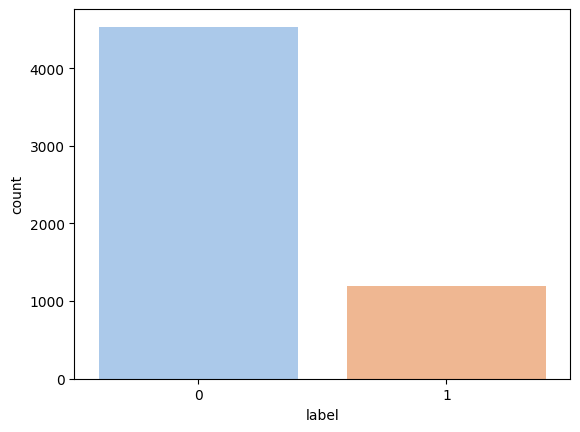

In [26]:
sns.countplot(x=label_2011_11,palette='pastel');
label_2011_11.value_counts()

## LightGBM Hyperparameter 선언
- early stopping 기능을 사용하기 위해 n_estimators, early_stopping_rounds 설정

In [58]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,
    'verbose_eval': 200,
}

## 2011년 12월 LightGBM 베이스라인 모델 예측
- Validation 성능 측정

In [62]:
train, test, y, features = feature_engineering1(data, '2011-12')
y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)

categorical feature: []
x_tr.shape (5722, 24) , x_te.shape (5914, 24)
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7679913375041647
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7980046644208344
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7869596057642052
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7508773239752108
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7842951750236518
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 6 | AUC: 0.79021277

In [63]:
print_score(label_2011_11, y_oof)

Precision: 0.65865
Recall: 0.23064
F1 Score: 0.34165
ROC AUC Score: 0.76788


## 2011년 12월 LightGBM 베이스라인 모델 예측 데이터 분포

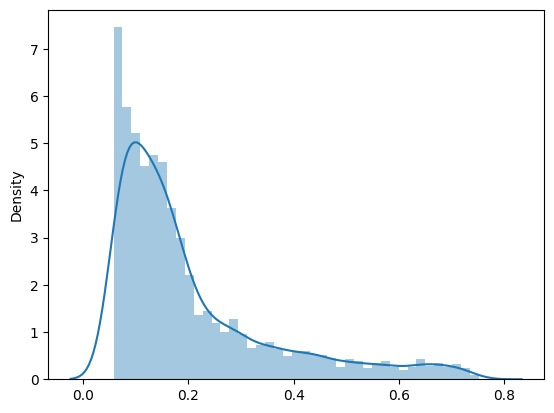

In [64]:
sns.distplot(test_preds)
plt.show()

## LightGBM 피처 중요도 플롯

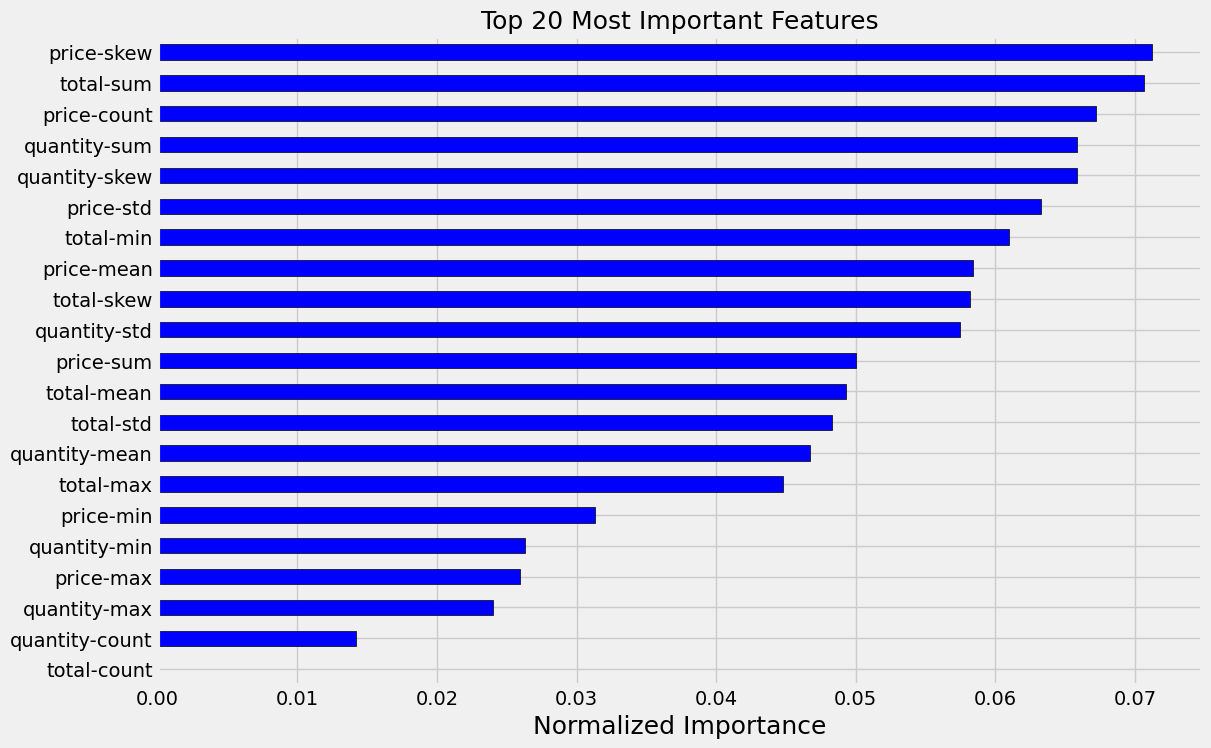

In [65]:
fi = plot_feature_importances(fi)

## Optuna Objective Function 정의

In [66]:
'''
    하이퍼파라미터 탐색 범위를 정의하고 튜닝 및 검증을 진행하는 함수
'''

def objective(trial, label=label_2011_11):
    lgb_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256), # num_leaves 값을 2-256까지 정수값 중에 사용
        'max_bin': trial.suggest_int('max_bin', 128, 256), # max_bin 값을 128-256까지 정수값 중에 사용
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'n_estimators': 10000, # 트리 개수
        'early_stopping_rounds': 100,
        # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'seed': SEED,
        'verbose': -1,
        'n_jobs': -1,
    }

    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=lgb_params)

    # Validation 스코어 계산
    val_auc = roc_auc_score(label, y_oof)

    return val_auc

## Optuna study 생성, auc이기 때문에 최대화 하는 방향으로 하이퍼 파라미터 탐색

In [67]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) # 10회 동안 하이퍼 파라미터 탐색

[I 2024-05-02 15:31:57,895] A new study created in memory with name: no-name-c08a6c25-65ef-4308-989f-b02ab94ae0bd


fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7477140635990079
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.789656831895754
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.771373105353543
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7222242962741732
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7569517873374515
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 6 | AUC: 0.7949802437531304
---------------------------------------------------------------

[I 2024-05-02 15:32:07,244] Trial 0 finished with value: 0.7660469197191738 and parameters: {'num_leaves': 93, 'max_bin': 165, 'min_data_in_leaf': 24, 'feature_fraction': 0.43527705667816896, 'bagging_fraction': 0.577870516630357, 'bagging_freq': 7, 'lambda_l1': 4.323227121706209e-08, 'lambda_l2': 0.10350606662986814}. Best is trial 0 with value: 0.7660469197191738.



Mean AUC = 0.766199951755767
OOF AUC = 0.7660469197191738
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7570151408581054
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.798430385370007
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7964515045172852
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7576625849324274
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7752796482831543
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 6 | AUC: 0.7939599680931976
---

[I 2024-05-02 15:32:16,561] Trial 1 finished with value: 0.7784599598395363 and parameters: {'num_leaves': 28, 'max_bin': 176, 'min_data_in_leaf': 36, 'feature_fraction': 0.492876747535913, 'bagging_fraction': 0.9781231148156164, 'bagging_freq': 2, 'lambda_l1': 0.01605815887001025, 'lambda_l2': 6.454002264037791e-05}. Best is trial 1 with value: 0.7784599598395363.


Fold 10 | AUC: 0.7703081232492996
--------------------------------------------------------------------------------

Mean AUC = 0.7788228434198611
OOF AUC = 0.7784599598395363
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7573298041683634
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7828452967089921
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7949581871126706
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7342641678488764
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7665609290073646
--------------------------------------------------------

[I 2024-05-02 15:32:21,706] Trial 2 finished with value: 0.7706049801054212 and parameters: {'num_leaves': 35, 'max_bin': 255, 'min_data_in_leaf': 35, 'feature_fraction': 0.4920449885220203, 'bagging_fraction': 0.7294164054099775, 'bagging_freq': 2, 'lambda_l1': 0.0016428412665633202, 'lambda_l2': 0.27906872923066395}. Best is trial 1 with value: 0.7784599598395363.


Fold 10 | AUC: 0.761125642309904
--------------------------------------------------------------------------------

Mean AUC = 0.7712922415491638
OOF AUC = 0.7706049801054212
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.756015622107874
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7991892792359234
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7660344956320466
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7172310162024939
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.765967314077949
-----------------------------------------------------------

[I 2024-05-02 15:32:31,150] Trial 3 finished with value: 0.7640867021932306 and parameters: {'num_leaves': 141, 'max_bin': 148, 'min_data_in_leaf': 21, 'feature_fraction': 0.5893475395714071, 'bagging_fraction': 0.7984096087159427, 'bagging_freq': 7, 'lambda_l1': 1.4351653858360474, 'lambda_l2': 0.0012044268934299097}. Best is trial 1 with value: 0.7784599598395363.


Fold 10 | AUC: 0.7511918674754671
--------------------------------------------------------------------------------

Mean AUC = 0.7646378477066145
OOF AUC = 0.7640867021932306
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.74232776811165
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7886202939325511
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.763159859628164
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7322295228850891
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7734431520952751
-----------------------------------------------------------

[I 2024-05-02 15:32:42,363] Trial 4 finished with value: 0.7661844886150135 and parameters: {'num_leaves': 240, 'max_bin': 155, 'min_data_in_leaf': 36, 'feature_fraction': 0.7569505690676188, 'bagging_fraction': 0.9369118786716435, 'bagging_freq': 2, 'lambda_l1': 0.0010318260545198149, 'lambda_l2': 0.013048260003345798}. Best is trial 1 with value: 0.7784599598395363.



Mean AUC = 0.7664844503009973
OOF AUC = 0.7661844886150135
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7614944656276607
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7897678895346685
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7939875307996714
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7602945568580602
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7740182165581464
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 6 | AUC: 0.7891924981913294
-

[I 2024-05-02 15:32:47,496] Trial 5 finished with value: 0.7777448243648067 and parameters: {'num_leaves': 49, 'max_bin': 129, 'min_data_in_leaf': 21, 'feature_fraction': 0.5112651100244716, 'bagging_fraction': 0.6129536016434247, 'bagging_freq': 2, 'lambda_l1': 4.336033911509247, 'lambda_l2': 4.507205411380894e-08}. Best is trial 1 with value: 0.7784599598395363.


Fold 10 | AUC: 0.7727011334335059
--------------------------------------------------------------------------------

Mean AUC = 0.7776533368191535
OOF AUC = 0.7777448243648067
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7383111835042386
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7966904823603449
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.790692899275741
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7418240872097364
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7727382343665943
---------------------------------------------------------

[I 2024-05-02 15:32:59,566] Trial 6 finished with value: 0.7689083898832465 and parameters: {'num_leaves': 145, 'max_bin': 172, 'min_data_in_leaf': 29, 'feature_fraction': 0.4823788388725004, 'bagging_fraction': 0.9919024775143187, 'bagging_freq': 3, 'lambda_l1': 1.1762430760353004e-06, 'lambda_l2': 2.57369534051916e-07}. Best is trial 1 with value: 0.7784599598395363.


Fold 10 | AUC: 0.7686200307937743
--------------------------------------------------------------------------------

Mean AUC = 0.7693207338420515
OOF AUC = 0.7689083898832465
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7267056602376634
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7565246362862325
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7461920406182333
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7442880609273501
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7610885413768156
--------------------------------------------------------

[I 2024-05-02 15:33:13,543] Trial 7 finished with value: 0.7500319323213015 and parameters: {'num_leaves': 139, 'max_bin': 256, 'min_data_in_leaf': 19, 'feature_fraction': 0.9249588086040011, 'bagging_fraction': 0.59753415016325, 'bagging_freq': 6, 'lambda_l1': 0.0029025859335670944, 'lambda_l2': 0.0007405790814661738}. Best is trial 1 with value: 0.7784599598395363.


Fold 10 | AUC: 0.7524069230341143
--------------------------------------------------------------------------------

Mean AUC = 0.7516626902419563
OOF AUC = 0.7500319323213015
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7520823307296486
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7977270203235478
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7777757037258269
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7269095796311507
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7672843972025897
--------------------------------------------------------

[I 2024-05-02 15:33:24,037] Trial 8 finished with value: 0.7686219272566868 and parameters: {'num_leaves': 94, 'max_bin': 219, 'min_data_in_leaf': 37, 'feature_fraction': 0.9075722411182757, 'bagging_fraction': 0.6829918838804728, 'bagging_freq': 3, 'lambda_l1': 0.2730126526339058, 'lambda_l2': 0.05314120359055049}. Best is trial 1 with value: 0.7784599598395363.


Fold 10 | AUC: 0.7537796575583876
--------------------------------------------------------------------------------

Mean AUC = 0.7683485303525502
OOF AUC = 0.7686219272566868
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7613186243660459
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7865472180061452
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7652691704621818
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7444373926678115
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7472684438013617
--------------------------------------------------------

[I 2024-05-02 15:33:29,519] Trial 9 finished with value: 0.7710929690969391 and parameters: {'num_leaves': 195, 'max_bin': 148, 'min_data_in_leaf': 33, 'feature_fraction': 0.8201041164917047, 'bagging_fraction': 0.4498905500004663, 'bagging_freq': 4, 'lambda_l1': 8.806322226894994e-05, 'lambda_l2': 0.29946715148680153}. Best is trial 1 with value: 0.7784599598395363.



Mean AUC = 0.7711940112850025
OOF AUC = 0.7710929690969391


## Validation 스코어가 가장 잘 나온 하이퍼 파라미터 출력

In [68]:
study.best_params

{'num_leaves': 28,
 'max_bin': 176,
 'min_data_in_leaf': 36,
 'feature_fraction': 0.492876747535913,
 'bagging_fraction': 0.9781231148156164,
 'bagging_freq': 2,
 'lambda_l1': 0.01605815887001025,
 'lambda_l2': 6.454002264037791e-05}

## 가장 성능이 잘 나온 Validation 스코어 출력

In [69]:
study.best_value

0.7784599598395363

## 하이퍼 파라미터 탐색 관련한 전체 데이터를 판다스 데이터 프레임으로 보기

In [70]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_max_bin,params_min_data_in_leaf,params_num_leaves,state
0,0,0.766047,2024-05-02 15:31:57.897956,2024-05-02 15:32:07.243320,0 days 00:00:09.345364,0.577871,7,0.435277,4.323227e-08,1.035061e-01,165,24,93,COMPLETE
1,1,0.778460,2024-05-02 15:32:07.254915,2024-05-02 15:32:16.560964,0 days 00:00:09.306049,0.978123,2,0.492877,1.605816e-02,6.454002e-05,176,36,28,COMPLETE
2,2,0.770605,2024-05-02 15:32:16.562756,2024-05-02 15:32:21.705586,0 days 00:00:05.142830,0.729416,2,0.492045,1.642841e-03,2.790687e-01,255,35,35,COMPLETE
3,3,0.764087,2024-05-02 15:32:21.707589,2024-05-02 15:32:31.149881,0 days 00:00:09.442292,0.798410,7,0.589348,1.435165e+00,1.204427e-03,148,21,141,COMPLETE
4,4,0.766184,2024-05-02 15:32:31.151747,2024-05-02 15:32:42.356230,0 days 00:00:11.204483,0.936912,2,0.756951,1.031826e-03,1.304826e-02,155,36,240,COMPLETE
5,5,0.777745,2024-05-02 15:32:42.371787,2024-05-02 15:32:47.496165,0 days 00:00:05.124378,0.612954,2,0.511265,4.336034e+00,4.507205e-08,129,21,49,COMPLETE
6,6,0.768908,2024-05-02 15:32:47.498674,2024-05-02 15:32:59.565980,0 days 00:00:12.067306,0.991902,3,0.482379,1.176243e-06,2.573695e-07,172,29,145,COMPLETE
7,7,0.750032,2024-05-02 15:32:59.567799,2024-05-02 15:33:13.543255,0 days 00:00:13.975456,0.597534,6,0.924959,2.902586e-03,7.405791e-04,256,19,139,COMPLETE
8,8,0.768622,2024-05-02 15:33:13.545268,2024-05-02 15:33:24.036766,0 days 00:00:10.491498,0.682992,3,0.907572,2.730127e-01,5.314120e-02,219,37,94,COMPLETE
9,9,0.771093,2024-05-02 15:33:24.039985,2024-05-02 15:33:29.519012,0 days 00:00:05.479027,0.449891,4,0.820104,8.806322e-05,2.994672e-01,148,33,195,COMPLETE


## 하이퍼 파라미터 중요도 Visualization

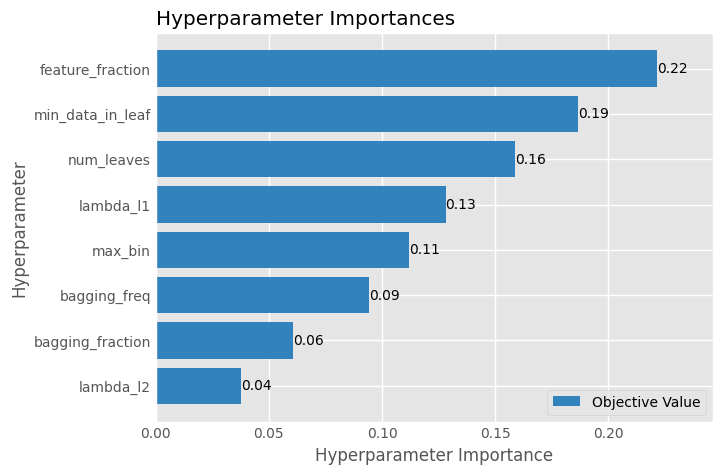

In [71]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

## 하이퍼 파라미터 탐색 히스토리 Visualization

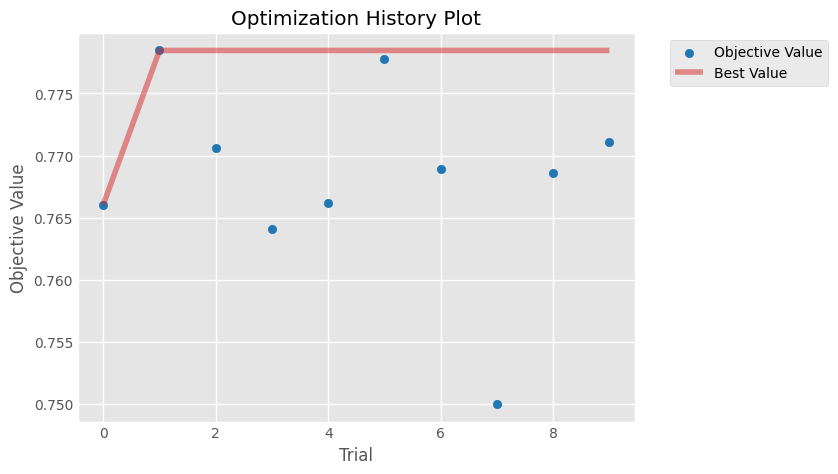

In [72]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

## 하이퍼 파라미터별 Validation 스코어의 관계 Visualization

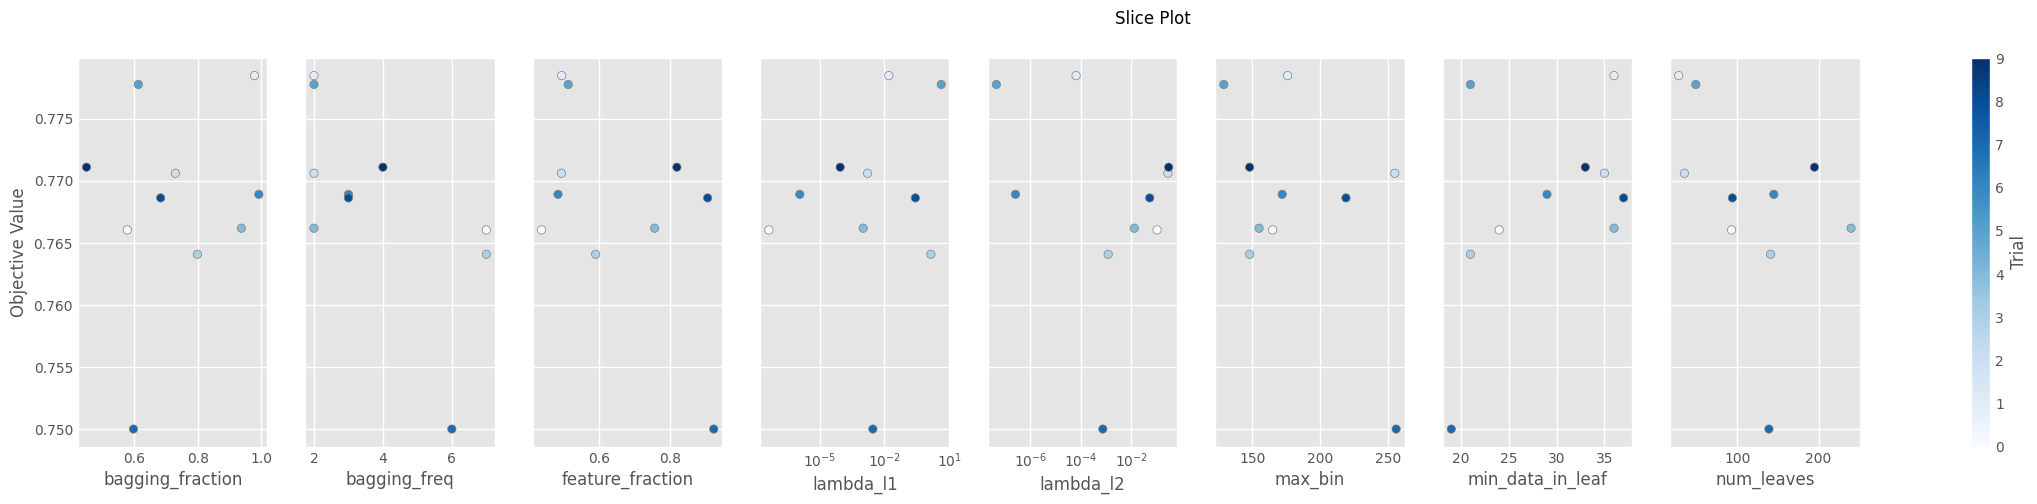

In [73]:
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

## 하이퍼 파라미터 Contour Visualization

[W 2024-05-02 15:34:07,027] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


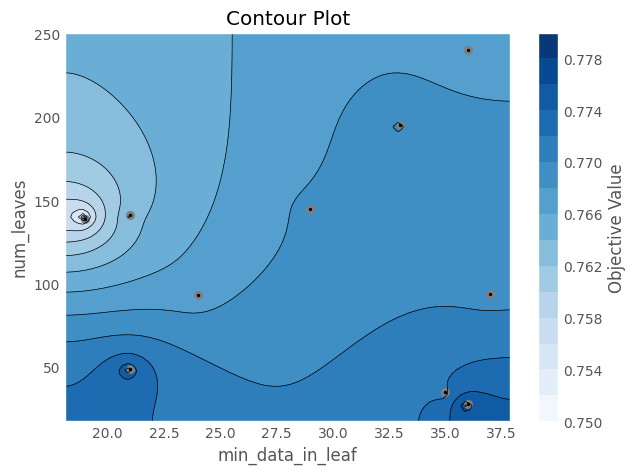

In [74]:
optuna.visualization.matplotlib.plot_contour(study, params=['num_leaves','min_data_in_leaf'])
plt.show()

## 하이퍼 파라미터 Parallel Coodinate Visualization

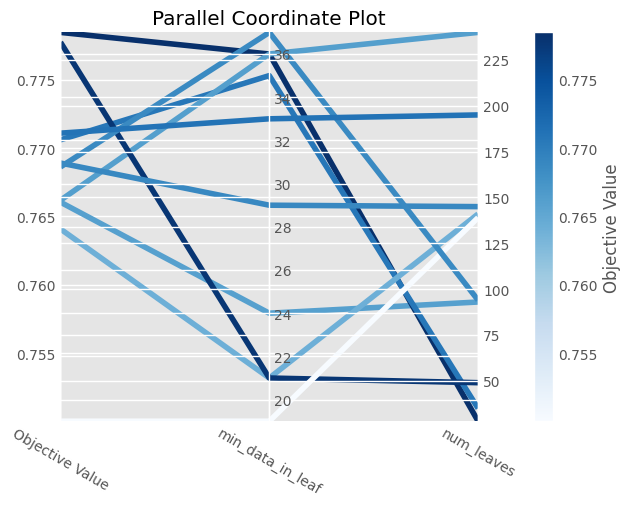

In [75]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['num_leaves','min_data_in_leaf'])
plt.show()

ALL RIGHTS RESERVED. (C)NAVER Connect Foundation.